In [2]:
# --- Step 1: Imports and Configuration ---
import yfinance as yf
import pandas as pd
import numpy as np
from pytrends.request import TrendReq
import pandas_ta as ta
from newsapi import NewsApiClient
from transformers import pipeline
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Suppress TensorFlow INFO messages for a cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from alpha_vantage.fundamentaldata import FundamentalData

# --- Configuration ---
# You can change these for any stock you want to analyze
STOCK_TICKER = "GOOGL"
COMPANY_NAME = "Google"

# -- API Keys (IMPORTANT: Use your NEW, secure keys here) --
NEWS_API_KEY = '1b97f324fd2a461b8483daa0d5449bf8'
ALPHA_VANTAGE_API_KEY = '64NN3MPVW4IE1VXF'

# --- THIS IS THE CORRECTED LINE ---
NEWS_QUERY = f'"{COMPANY_NAME}" OR "{STOCK_TICKER}"'
# --- END OF CORRECTION ---

# -- Date Range --
START_DATE = "2020-01-01"
END_DATE = date.today().strftime("%Y-%m-%d") # Automatically uses today's date

print("Configuration and libraries are set.")

Configuration and libraries are set.


In [3]:
# --- Step 2: Data Collection ---
print("--- Phase 1: Data Collection ---")

# 1. Price Data for Stock and VIX
print(f"Fetching price data for {STOCK_TICKER} and VIX...")
raw_price_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
vix_df = yf.download('^VIX', start=START_DATE, end=END_DATE)

# 2. Google Trends Data (with robust error handling)
print("Fetching Google Trends data...")
try:
    pytrends = TrendReq(hl='en-US', tz=360, timeout=(10, 25), retries=3)
    pytrends.build_payload(kw_list=[COMPANY_NAME], timeframe=f'{START_DATE} {END_DATE}')
    trends_df = pytrends.interest_over_time()
    if trends_df.empty:
        print("Warning: No Google Trends data found for the given timeframe.")
        # If it's empty but no error, create a placeholder
        trends_df = pd.DataFrame(index=raw_price_df.index, columns=[COMPANY_NAME]).fillna(0)
    else:
        print("Google Trends data fetched successfully.")
except Exception as e:
    print(f"WARNING: Could not fetch Google Trends data due to a network error: {e}")
    print("--> Proceeding without the Google Trends feature.")
    # Create an empty DataFrame with the right index so the merge doesn't fail
    trends_df = pd.DataFrame(index=raw_price_df.index, columns=[COMPANY_NAME]).fillna(0)

# 3. News Data
print("Fetching news data...")
newsapi = NewsApiClient(api_key=NEWS_API_KEY)
all_articles = newsapi.get_everything(q=NEWS_QUERY, language='en', sort_by='publishedAt', page_size=100)
raw_news_df = pd.DataFrame(all_articles['articles'])

# 4. Fundamental Data (Earnings Per Share)
print("Fetching fundamental (EPS) data...")
try:
    fd = FundamentalData(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    earnings_data, _ = fd.get_earnings(STOCK_TICKER)
    earnings_data['reportedEPS'] = pd.to_numeric(earnings_data['reportedEPS'], errors='coerce')
    earnings_df = earnings_data[['fiscalDateEnding', 'reportedEPS']].copy()
    earnings_df.dropna(inplace=True)
    print("Fundamental data fetched successfully.")
except Exception as e:
    print(f"WARNING: Could not fetch fundamental data from Alpha Vantage: {e}")
    print("--> Proceeding without the EPS feature.")
    earnings_df = pd.DataFrame() # Create an empty df if the call fails

print("--- Data collection complete. ---")

--- Phase 1: Data Collection ---
Fetching price data for GOOGL and VIX...


C:\Users\vasam\AppData\Local\Temp\ipykernel_11528\112308490.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_price_df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
C:\Users\vasam\AppData\Local\Temp\ipykernel_11528\112308490.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_df = yf.download('^VIX', start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Fetching Google Trends data...


c:\Users\vasam\stock-prediction-project\env\lib\site-packages\pytrends\request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Google Trends data fetched successfully.
Fetching news data...
Fetching fundamental (EPS) data...
--> Proceeding without the EPS feature.
--- Data collection complete. ---


In [4]:
# --- Step 3: Sentiment Analysis and Initial Cleaning ---
print("\n--- Phase 2: Sentiment and Initial Cleaning ---")

# Clean Price Data
price_df = raw_price_df.copy()
if isinstance(price_df.columns, pd.MultiIndex):
    price_df.columns = price_df.columns.get_level_values(0)
price_df.dropna(inplace=True)

# Filter News and Run Sentiment Analysis
news_df_filtered = raw_news_df[raw_news_df['title'].str.contains(f"{COMPANY_NAME}|{STOCK_TICKER}", case=False, na=False)].copy()
if not news_df_filtered.empty:
    sentiment_analyzer = pipeline('sentiment-analysis', model="ProsusAI/finbert")
    news_df_filtered['Date'] = pd.to_datetime(news_df_filtered['publishedAt']).dt.date
    news_df_filtered['Date'] = pd.to_datetime(news_df_filtered['Date'])
    headlines = news_df_filtered['title'].tolist()
    sentiment_scores = sentiment_analyzer(headlines)
    sentiment_map = {'positive': 1, 'negative': -1, 'neutral': 0}
    news_df_filtered['sentiment'] = [sentiment_map[s['label']] * s['score'] for s in sentiment_scores]
    daily_sentiment = news_df_filtered.groupby('Date')['sentiment'].mean().to_frame()
    daily_sentiment.rename(columns={'sentiment': 'avg_sentiment'}, inplace=True)
    print(f"Sentiment analysis complete on {len(news_df_filtered)} articles.")
else:
    daily_sentiment = None
    print("No relevant news found for sentiment analysis.")


--- Phase 2: Sentiment and Initial Cleaning ---


Device set to use cpu


Sentiment analysis complete on 19 articles.


In [5]:
print("\n--- Phase 3: Advanced Feature Engineering ---")

# Start with the cleaned price data
master_df = price_df.copy()

# Add VIX and Google Trends
master_df['VIX_Close'] = vix_df['Close']
if not trends_df.empty:
    master_df = master_df.join(trends_df[COMPANY_NAME])
    master_df.rename(columns={COMPANY_NAME: 'google_trends'}, inplace=True)
else:
    master_df['google_trends'] = 0

# Add quarterly EPS data (forward-filled)
if not earnings_df.empty:
    earnings_df['fiscalDateEnding'] = pd.to_datetime(earnings_df['fiscalDateEnding'])
    earnings_df.set_index('fiscalDateEnding', inplace=True)
    eps_daily = earnings_df['reportedEPS'].reindex(master_df.index, method='ffill')
    master_df['EPS'] = eps_daily
else:
    master_df['EPS'] = 0

# Add technical indicators
master_df.ta.rsi(length=14, append=True)
master_df.ta.macd(append=True)

# Add returns as a feature
master_df['returns'] = master_df['Close'].pct_change()

# Join sentiment data
if daily_sentiment is not None:
    master_df = master_df.join(daily_sentiment)
else:
    master_df['avg_sentiment'] = 0

# Final cleanup
master_df.fillna(0, inplace=True) # Fill any NaNs from joins/trends
master_df.dropna(inplace=True)   # Drop NaNs created by technical indicators/returns

print("Advanced Feature Engineering complete.")
master_df.info()


--- Phase 3: Advanced Feature Engineering ---
Advanced Feature Engineering complete.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1426 entries, 2020-01-02 to 2025-09-04
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Close          1426 non-null   float64
 1   High           1426 non-null   float64
 2   Low            1426 non-null   float64
 3   Open           1426 non-null   float64
 4   Volume         1426 non-null   int64  
 5   VIX_Close      1426 non-null   float64
 6   google_trends  1426 non-null   float64
 7   EPS            1426 non-null   int64  
 8   RSI_14         1426 non-null   float64
 9   MACD_12_26_9   1426 non-null   float64
 10  MACDh_12_26_9  1426 non-null   float64
 11  MACDs_12_26_9  1426 non-null   float64
 12  returns        1426 non-null   float64
 13  avg_sentiment  1426 non-null   float64
dtypes: float64(12), int64(2)
memory usage: 199.4 KB


In [6]:
# --- Step 4: Scaling and Sequencing ---
print("\n--- Phase 4: Final Data Preparation ---")

# Scale all features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(master_df)
scaled_df = pd.DataFrame(scaled_data, columns=master_df.columns, index=master_df.index)

# Create Sequences
SEQUENCE_LENGTH = 60
TARGET_COLUMN_INDEX = scaled_df.columns.get_loc('Close')
X, y = [], []
X_data = scaled_df.to_numpy()
y_data = scaled_df['Close'].to_numpy()

for i in range(SEQUENCE_LENGTH, len(scaled_data)):
    X.append(X_data[i-SEQUENCE_LENGTH:i, :])
    y.append(y_data[i])

X, y = np.array(X), np.array(y)
print(f"X shape: {X.shape}, y shape: {y.shape}")


--- Phase 4: Final Data Preparation ---
X shape: (1366, 60, 14), y shape: (1366,)


In [7]:
# --- Step 5: Data Splitting ---
SPLIT_RATIO = 0.8
split_index = int(len(X) * SPLIT_RATIO)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (1092, 60, 14), X_test shape: (274, 60, 14)


In [8]:
# --- Step 6: Build the Model ---
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(units=100, return_sequences=False),
    Dropout(0.2),
    Dense(units=50, activation='relu'),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 128)           5504      
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                     

In [9]:
# --- Step 7: Train the Model ---
EPOCHS = 50
BATCH_SIZE = 32
print(f"\nTraining the Ultimate model for {EPOCHS} epochs...")
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test),
                    verbose=1)
print("Model training complete.")


Training the Ultimate model for 50 epochs...
Epoch 1/50

35/35 [==============================] - 2s 17ms/step - loss: 0.0207 - val_loss: 0.0042
Epoch 2/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0082
Epoch 5/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 6/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 7/50
35/35 [==============================] - 0s 9ms/step - loss: 9.7866e-04 - val_loss: 0.0038
Epoch 8/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0070
Epoch 9/50
35/35 [==============================] - 0s 9ms/step - loss: 8.5828e-04 - val_loss: 0.0041
Epoch 10/50
35/35 [==============================] - 0s 9ms/st

Plotting model loss...


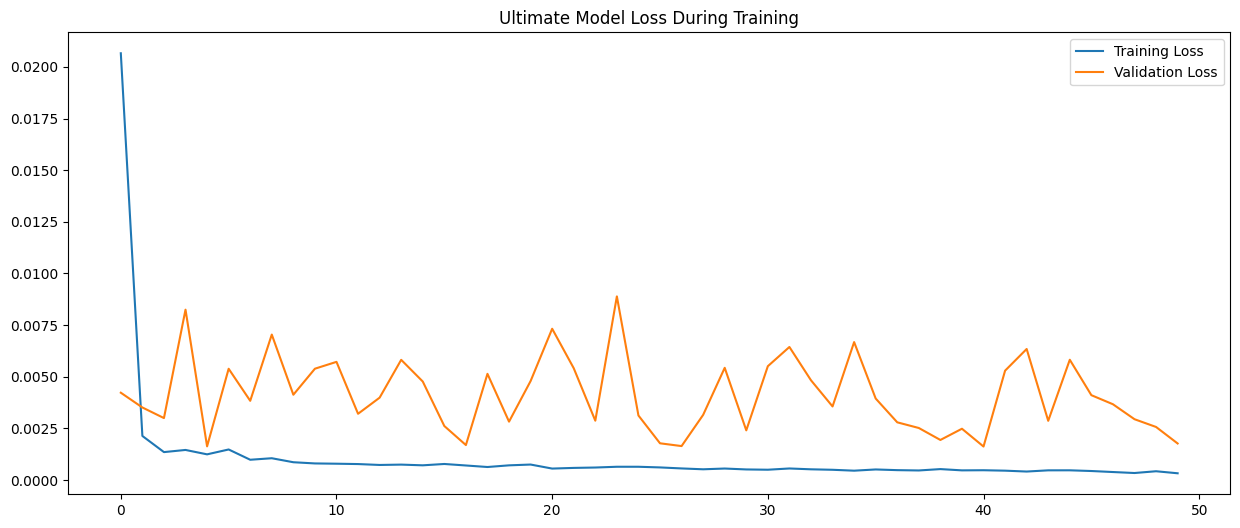


Making predictions...
9/9 [==============================] - 0s 4ms/step

Plotting actual vs. predicted prices...


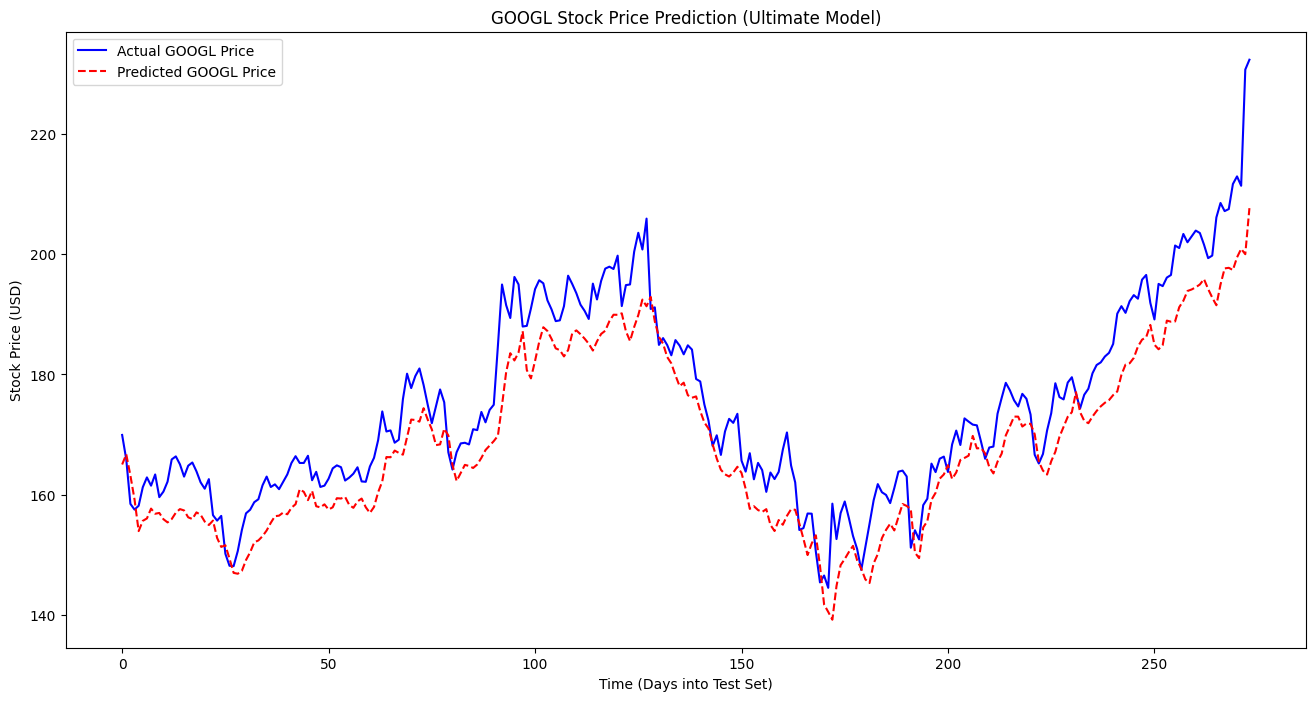

In [10]:
# --- Step 8: Evaluate and Visualize ---
print("Plotting model loss...")
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Ultimate Model Loss During Training')
plt.legend()
plt.show()

print("\nMaking predictions...")
predictions_scaled = model.predict(X_test)

# Inverse transform predictions
num_features = X.shape[2]
dummy_array = np.zeros((len(predictions_scaled), num_features))
dummy_array[:, TARGET_COLUMN_INDEX] = predictions_scaled.ravel()
predictions = scaler.inverse_transform(dummy_array)[:, TARGET_COLUMN_INDEX]

# Inverse transform actual prices
dummy_y_test = np.zeros((len(y_test), num_features))
dummy_y_test[:, TARGET_COLUMN_INDEX] = y_test.ravel()
actual_prices = scaler.inverse_transform(dummy_y_test)[:, 0]

# Plot the final results
print("\nPlotting actual vs. predicted prices...")
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, color='blue', label=f'Actual {STOCK_TICKER} Price')
plt.plot(predictions, color='red', linestyle='--', label=f'Predicted {STOCK_TICKER} Price')
plt.title(f'{STOCK_TICKER} Stock Price Prediction (Ultimate Model)')
plt.xlabel('Time (Days into Test Set)')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [12]:
# Get the correct dates for the test set
test_dates = master_df.index[split_index + SEQUENCE_LENGTH:]

# Create and save the DataFrame WITH the date index
pd.DataFrame({
    'Actual': actual_prices, 
    'Predicted_CNN_LSTM': predictions
}, index=test_dates).to_csv('predictions_cnn_lstm.csv', index=True, index_label='Date')

print("SUCCESS: CNN-LSTM predictions saved with date index.")

SUCCESS: CNN-LSTM predictions saved with date index.



--- Ultimate CNN-LSTM Model: Comprehensive Performance Metrics ---
Root Mean Squared Error (RMSE): $7.56
Mean Absolute Error (MAE):      $6.46
Mean Absolute Percentage Error (MAPE): 3.63%
R-Squared (R²):                 0.78
Directional Accuracy:           44.89%
--------------------------------------------------------------------


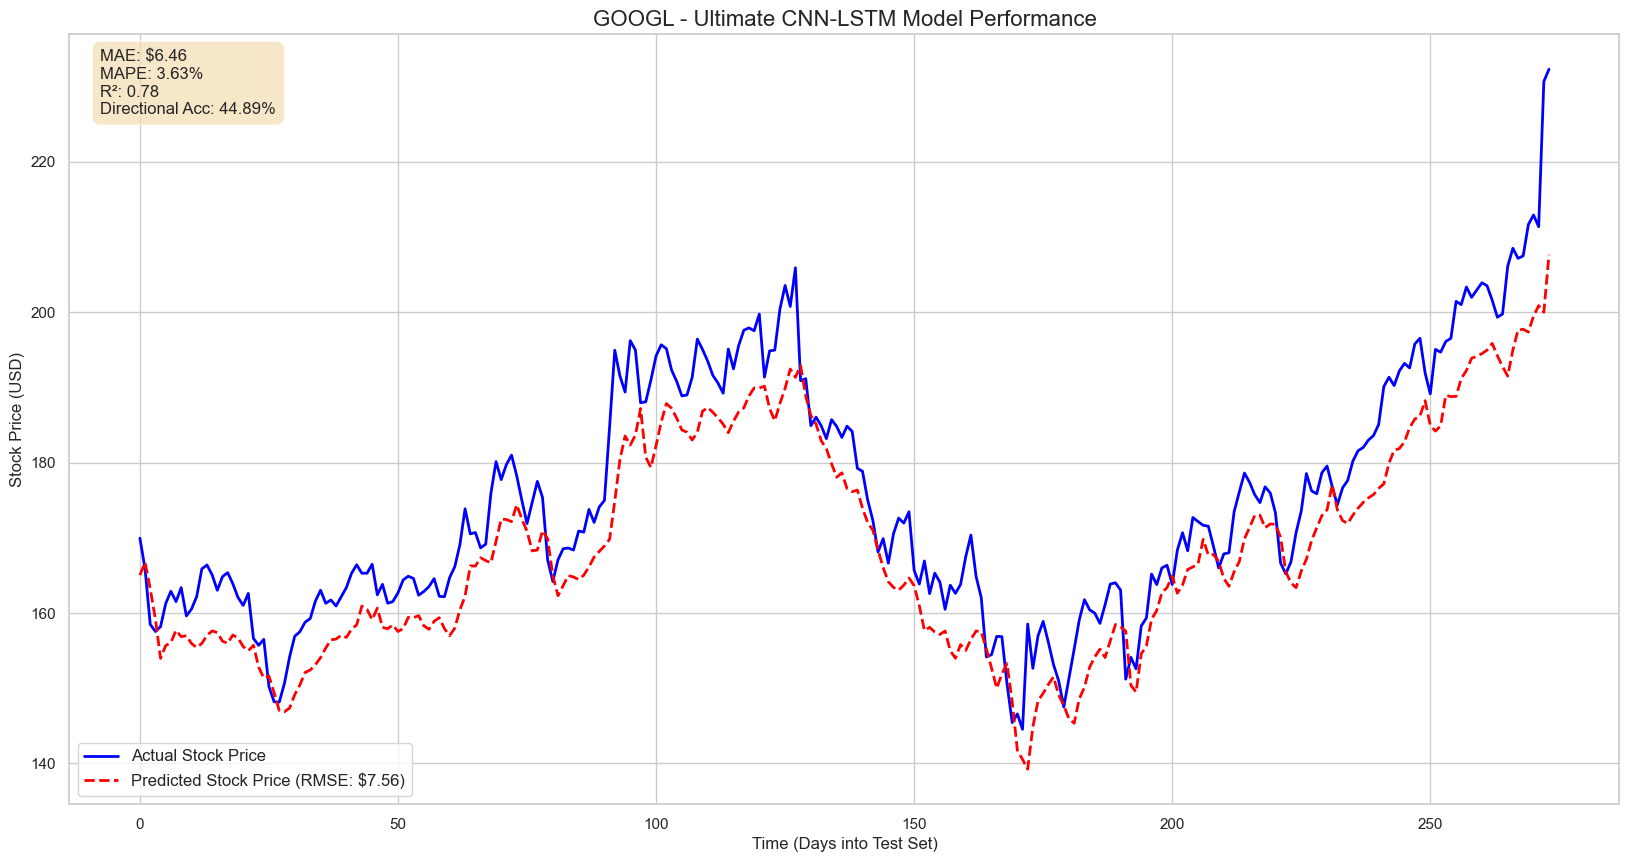

In [13]:
# --- FINAL ACCURACY TESTS for the Ultimate CNN-LSTM Model ---
# Note: This cell assumes 'actual_prices' and 'predictions' variables exist from the previous cell.

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import numpy as np

# --- 1. Calculate the Full Suite of Metrics ---

# Error Metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
mae = mean_absolute_error(actual_prices, predictions)
mape = mean_absolute_percentage_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

# Directional Accuracy
# Create a DataFrame to make calculations easier
actual_vs_pred = pd.DataFrame({'Actual': actual_prices, 'Predicted': predictions})

# The actual daily move is the difference between today's price and yesterday's
actual_vs_pred['Actual_Move'] = actual_vs_pred['Actual'].diff()

# The predicted move is the difference between today's prediction and yesterday's ACTUAL price
actual_vs_pred['Predicted_Move'] = actual_vs_pred['Predicted'] - pd.Series(actual_prices).shift(1).values

# Check if the sign of the move is the same (e.g., both are positive or both are negative)
actual_vs_pred['Correct_Direction'] = np.sign(actual_vs_pred['Actual_Move']) == np.sign(actual_vs_pred['Predicted_Move'])

# The final directional accuracy is the average of the 'Correct_Direction' column
directional_accuracy = actual_vs_pred['Correct_Direction'].mean() * 100


# --- 2. Print a Clean Summary Report ---
print("\n--- Ultimate CNN-LSTM Model: Comprehensive Performance Metrics ---")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Error (MAE):      ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")
print(f"R-Squared (R²):                 {r2:.2f}")
print(f"Directional Accuracy:           {directional_accuracy:.2f}%")
print("--------------------------------------------------------------------")


# --- 3. Generate the Final Plot with Metrics ---
plt.figure(figsize=(20, 10))
sns.set_theme(style="whitegrid")

plt.plot(actual_prices, color='blue', label='Actual Stock Price', linewidth=2)
plt.plot(predictions, color='red', linestyle='--', label=f'Predicted Stock Price (RMSE: ${rmse:.2f})', linewidth=2)

plt.title(f'{STOCK_TICKER} - Ultimate CNN-LSTM Model Performance', fontsize=16)
plt.xlabel('Time (Days into Test Set)', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)

# Add the metrics as a text box on the plot for a professional finish
metrics_text = (f"MAE: ${mae:.2f}\n"
                f"MAPE: {mape:.2%}\n"
                f"R²: {r2:.2f}\n"
                f"Directional Acc: {directional_accuracy:.2f}%")

plt.text(0.02, 0.98, metrics_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))

plt.legend(fontsize=12)
plt.show()